# FEM Assembling

$$-u''(x) = 1$$

mit homogenen RW

In [1]:
def uanalytic(x):
    return -0.5*x*(x-1)

## 1. Ordnung

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Elementsteiffigkeitsmatrix
order = 1
Ae = np.array([[1,-1],[-1,1]])

# Zerlegung des Gebiets
n=5;a=0;b=1
xi = np.linspace(a,b,n+1)
h = xi[1:]-xi[:-1]

# lokal - global mapping
N = n+1
T = np.array([[i,i+1] for i in range(N)])

# Globale Steiffigkeitsmatrix
A = np.zeros((N,N))

# Loop über Elemente (Assembling)
for i in range(n):
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]
A

array([[ 5., -5.,  0.,  0.,  0.,  0.],
       [-5., 10., -5.,  0.,  0.,  0.],
       [ 0., -5., 10., -5.,  0.,  0.],
       [ 0.,  0., -5., 10., -5.,  0.],
       [ 0.,  0.,  0., -5., 10., -5.],
       [ 0.,  0.,  0.,  0., -5.,  5.]])

In [3]:
from scipy.integrate import quad
# Referenz Elementfunktionen
def phi(t,i):
    if i == 0:
        return 1-t
    else:
        return t

# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

# Globale Vektor der Linearform
f = np.zeros(N)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Vektor
    fe = [quad(lambda t: func(sigma(t,i))*phi(t,j), 0,1)[0] for j in range(order+1)]
    for j in range(order+1):
        f[T[i,j]] += h[i]*fe[j]
f

array([0.1, 0.2, 0.2, 0.2, 0.2, 0.1])

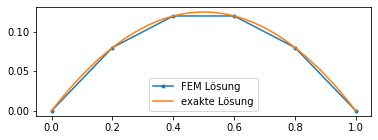

In [4]:
ui = np.zeros_like(xi)
ui[1:-1] = np.linalg.solve(A[1:-1,1:-1],f[1:-1])

xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xi,ui,'.-',label='FEM Lösung')
ax.plot(xp,uanalytic(xp),label='exakte Lösung')
ax.legend()

## 2. Ordnung Lagrange Basis Funktionen

In [5]:
from sympy.abc import x as symbx
from sympy import lambdify

In [6]:
order = 2

In [7]:
def lagrangePoly(x,j,order):
    xi = np.linspace(0,1,order+1)
    J = np.delete(np.arange(order+1),j)
    return np.product([(x-xi[i])/(xi[j]-xi[i]) for i in J],axis=0)

In [8]:
Ae = np.array([[quad(lambdify(symbx,lagrangePoly(symbx,i,order).diff()*lagrangePoly(symbx,j,order).diff()),0,1)[0]
                 for i in range(order+1)] for j in range(order+1)],dtype=np.float)

In [9]:
Ae

array([[ 2.33333333, -2.66666667,  0.33333333],
       [-2.66666667,  5.33333333, -2.66666667],
       [ 0.33333333, -2.66666667,  2.33333333]])

In [10]:
# Zerlegung des Gebiets
n=5;a=0;b=1
xi = np.linspace(a,b,n+1)
h = xi[1:]-xi[:-1]

# lokal - global mapping
N = n+1
T = np.array([[i,i+1,i+2] for i in range(0,2*n,2)])
T

array([[ 0,  1,  2],
       [ 2,  3,  4],
       [ 4,  5,  6],
       [ 6,  7,  8],
       [ 8,  9, 10]])

In [11]:
# Globale Steiffigkeitsmatrix
A = np.zeros((2*n+1,2*n+1))

# Loop über Elemente (Assembling)
for i in range(n):
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]

In [12]:
from scipy.integrate import quad

# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

def invsigma(x,i):
    return (x-xi[i])/h[i]

# Globale Vektor der Linearform
f = np.zeros(2*n+1)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Vektor
    fe = [quad(lambda t: func(sigma(t,i))*lagrangePoly(t,j,order), 0,1)[0] for j in range(order+1)]
    for j in range(order+1):
        f[T[i,j]] += h[i]*fe[j]
f

array([0.03333333, 0.13333333, 0.06666667, 0.13333333, 0.06666667,
       0.13333333, 0.06666667, 0.13333333, 0.06666667, 0.13333333,
       0.03333333])

In [13]:
ui = np.zeros(2*n+1)
ui[1:-1] = np.linalg.solve(A[1:-1,1:-1],f[1:-1])
ui

array([0.   , 0.045, 0.08 , 0.105, 0.12 , 0.125, 0.12 , 0.105, 0.08 ,
       0.045, 0.   ])

In [14]:
def visu(x,ui):
    res = np.zeros_like(x)
    for i in range(n):
        if i < n-1:
            ind = (xi[i]<=x)*(x<xi[i+1])
        else:
            ind = (xi[i]<=x)*(x<=xi[i+1])
        for j in range(order+1):
            res[ind] += ui[T[i,j]]*lagrangePoly(invsigma(x[ind],i),j,order)
    return res

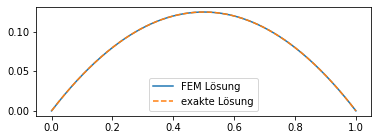

In [15]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui),'-',label='FEM Lösung')
ax.plot(xp,uanalytic(xp),'--',label='exakte Lösung')
ax.legend()

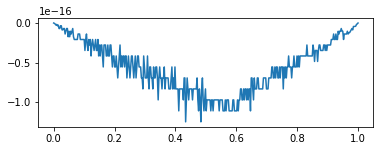

In [16]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui)-uanalytic(xp),'-')

## 2. Ordnung hierarchische Basis Funktionen

In [17]:
from sympy.abc import x as symbx
from sympy import lambdify

In [18]:
order = 2

In [19]:
def lagrangePoly(x,j,order):
    xi = np.linspace(0,1,order+1)
    J = np.delete(np.arange(order+1),j)
    return np.product([(x-xi[i])/(xi[j]-xi[i]) for i in J],axis=0)

In [20]:
def myshape2(x,j):
    if j == 0:
        return 1-x
    elif j == 1:
        return x
    else: 
        return x*(1-x)


In [21]:
Ae = np.array([[quad(lambdify(symbx,myshape2(symbx,i).diff()*myshape2(symbx,j).diff()),0,1)[0]
                 for i in range(order+1)] for j in range(order+1)],dtype=np.float)

In [22]:
np.round(Ae,4)

array([[ 1.    , -1.    ,  0.    ],
       [-1.    ,  1.    , -0.    ],
       [ 0.    , -0.    ,  0.3333]])

In [23]:
# Zerlegung des Gebiets
n=5;a=0;b=1
xi = np.linspace(a,b,n+1)
h = xi[1:]-xi[:-1]

# lokal - global mapping
N = n+1
T = np.array([[i,i+2,i+1] for i in range(0,2*n,2)])
T

array([[ 0,  2,  1],
       [ 2,  4,  3],
       [ 4,  6,  5],
       [ 6,  8,  7],
       [ 8, 10,  9]])

In [24]:
# Globale Steiffigkeitsmatrix
A = np.zeros((2*n+1,2*n+1))

# Loop über Elemente (Assembling)
for i in range(n):
    for j in range(order+1):
        for k in range(order+1):
            A[T[i,j],T[i,k]] += Ae[j,k]/h[i]

In [25]:
from scipy.integrate import quad

# Rechteseite der DGL
def func(x):
    return np.ones_like(x)

# Koordinaten Transformation
def sigma(t,i):
    return xi[i]+t*h[i]

def invsigma(x,i):
    return (x-xi[i])/h[i]

# Globale Vektor der Linearform
f = np.zeros(2*n+1)

# Loop über Elemente (Assembling)
for i in range(n):
    # berechne lokaler Vektor
    fe = [quad(lambda t: func(sigma(t,i))*myshape2(t,j), 0,1)[0] for j in range(order+1)]
    for j in range(order+1):
        f[T[i,j]] += h[i]*fe[j]
f

array([0.1       , 0.03333333, 0.2       , 0.03333333, 0.2       ,
       0.03333333, 0.2       , 0.03333333, 0.2       , 0.03333333,
       0.1       ])

In [26]:
ui = np.zeros(2*n+1)
ui[1:-1] = np.linalg.solve(A[1:-1,1:-1],f[1:-1])
ui

array([0.  , 0.02, 0.08, 0.02, 0.12, 0.02, 0.12, 0.02, 0.08, 0.02, 0.  ])

In [27]:
def visu(x,ui):
    res = np.zeros_like(x)
    for i in range(n):
        if i < n-1:
            ind = (xi[i]<=x)*(x<xi[i+1])
        else:
            ind = (xi[i]<=x)*(x<=xi[i+1])
        for j in range(order+1):
            res[ind] += ui[T[i,j]]*myshape2(invsigma(x[ind],i),j)
    return res

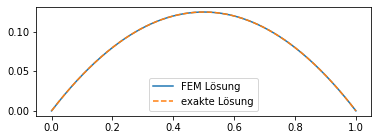

In [28]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui),'-',label='FEM Lösung')
ax.plot(xp,uanalytic(xp),'--',label='exakte Lösung')
ax.legend()

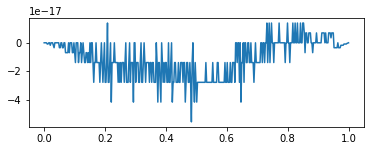

In [29]:
xp = np.linspace(0,1,400)
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(xp,visu(xp,ui)-uanalytic(xp),'-')